In [2]:
import brian2.only as b2
from brian2 import np, mwatt, mV, mm, mm2, nmeter, cm, ufarad, Mohm, ms, Hz, msiemens, pA, nA, uA, volt, second, siemens ,Hz
import cleo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib widget

### Make a network of 15x9 grid squares with each square having around 20 neurons

In [3]:
width=1.5
height=0.9
depth=0.3
xmax_mm = width
density = 500
n = int(width * height * depth * density)

# colors
c = {
    "main": "#C500CC",
    "473nm": "#72b5f2",
    "590nm": (1, 0.875, 0),
}

ng = b2.NeuronGroup(
    n,
    """
    dv/dt = (
        -(v - E_L)
        + Delta_T*exp((v-theta)/Delta_T)
        + Rm*(I_exc + I_inh + I_bg + I_enphr)
    ) / tau_m + sigma*sqrt(2/tau_m)*xi: volt
    I_exc : amp
    I_inh : amp
    I_enphr : amp
    """,
    threshold="v > -10*mV",
    reset="v=E_L",
    namespace={
        "tau_m": 20 * ms,
        "Rm": 500 * b2.Mohm,
        "theta": -50 * mV,
        "Delta_T": 2 * mV,
        "E_L": -70 * mV,
        "sigma": 5 * mV,
        "I_bg": 20 * pA,
    },
)
ng.v = np.random.uniform(-70, -60, n) * mV

W = 1 * mV
p_S = 0.3
n_neighbors = 40
S_ee = b2.Synapses(ng, model="w: 1", on_pre="v_post+=W*w/sqrt(N)")
S_ee.connect(condition="abs(i-j)<=n_neighbors and i!=j")
S_ee.w = np.exp(np.random.randn(int(S_ee.N - 0))) * np.random.choice(
    [-1, 1], int(S_ee.N - 0)
)

spike_mon = b2.SpikeMonitor(ng)
# for visualizing currents
Imon = b2.StateMonitor(ng, ("I_exc", "I_inh", "I_enphr"), record=range(20))
net = b2.Network(ng, S_ee, spike_mon, Imon)
sim = cleo.CLSimulator(net)

tissue_depth_mm = 0.3
# cleo.coords.assign_coords_grid_rect_prism(ng, xlim=(0, w), ylim=(0,h), zlim=(0, tissue_depth_mm), shape=(15,9,3))
cell_locs = cleo.coords.assign_coords_rand_rect_prism(ng, xlim=(0, width), ylim=(0,height), zlim=(0, depth), )

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


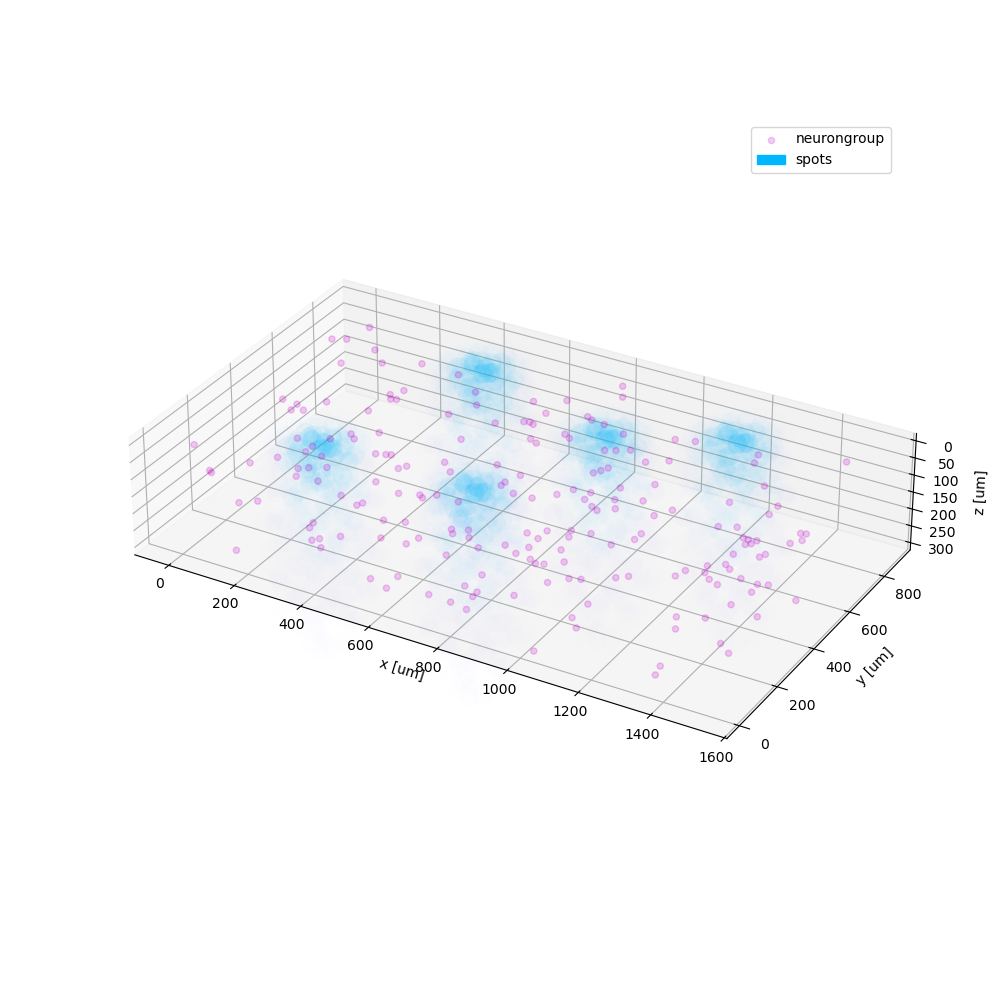

In [4]:
n_spots = 5
stim_coords = np.array([
                    [0.30,0.20,0.0],
                    [0.45,0.75,0.0],
                    [0.75,0.20,0.0],
                    [0.90,0.60,0.0],
                    [1.20,0.75,0.0]
                ])
end_space = 1 / (2 * n_spots)

spots = cleo.light.Light(
    coords=stim_coords * mm,
    name = 'spots',
    light_model=cleo.light.fiber473nm(),
    wavelength=473*b2.nmeter,
)
sim.inject(spots, ng)
chr2 = cleo.opto.chr2_4s()
sim.inject(chr2, ng, Iopto_var_name="I_exc")

fig,ax = cleo.viz.plot(ng, colors=[c["main"]], sim=sim)
# increase the size and save the fig
fig.set_size_inches(10, 10)
fig.savefig("optical_transfer_function_5sq.png")
fig.savefig("optical_transfer_function_5sq.svg")

In [5]:
from cleo.ioproc import LatencyIOProcessor
# https://cleosim.readthedocs.io/latest/tutorials/multi_opto.html#injecting-a-multi-channel-light


class OpenLoopOpto(LatencyIOProcessor):
    def __init__(self):
        super().__init__(sample_period=1 * ms)

    # since this is open-loop, we don't use state_dict
    def process(self, state_dict, t_samp):
        amplitude = 0.5 * mwatt / mm2
        time_offsets = np.array([0, -50,-100,-150,-200]) 
        t = t_samp / ms + time_offsets
        blue = (((t >= 100) & (t < 120)) | ((t >= 300) & (t < 320))) * amplitude
        # return output dict and time
        return ({"spots": blue}, t_samp)


sim.set_io_processor(OpenLoopOpto())

CLSimulator(io_processor=OpenLoopOpto(sample_period=1. * msecond, sampling='fixed', processing='parallel'), devices={Light(name='spots', save_history=True, value=array([0., 0., 0., 0., 0.]), light_model=OpticFiber(R0=100. * umetre, NAfib=0.37, K=125. * metre ** -1, S=7370. * metre ** -1, ntis=1.36), wavelength=0.473 * umetre, direction=array([0., 0., 1.]), max_value=None, max_value_viz=None), FourStateOpsin(name='ChR2', save_history=True, on_pre='', spectrum=[(400, 0.34), (422, 0.65), (460, 0.96), (470, 1), (473, 1), (500, 0.57), (520, 0.22), (540, 0.06), (560, 0.01), (800, 1.257478763901864e-06), (844, 2.404003519224151e-06), (920, 3.5505282745464387e-06), (940, 3.6984669526525404e-06), (946, 3.6984669526525404e-06), (1000, 2.1081261630119477e-06), (1040, 8.136627295835588e-07), (1080, 2.2190801715915242e-07), (1120, 3.69846695265254e-08)], extrapolate=False, required_vars=[('Iopto', amp), ('v', volt)], g0=114. * nsiemens, gamma=0.00742, phim=2.33e+23 * (second ** -1) / (meter ** 2), 

In [6]:
sim.reset()
sim.run(1000 * ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.03s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_ChR2_neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.03s). [brian2.stateupdaters.base.method_choice]


(0.0, 1000.0)

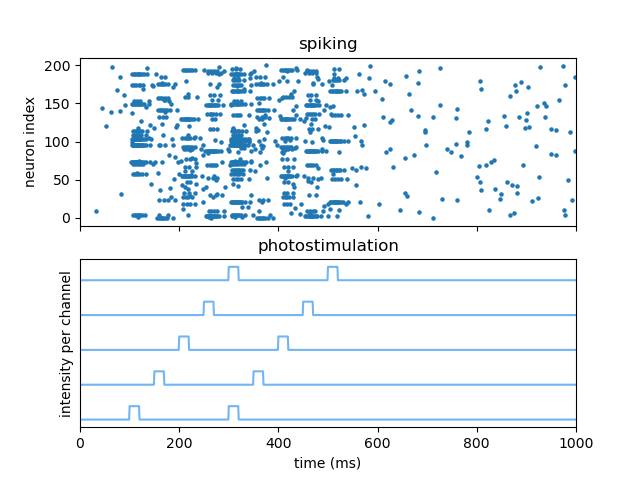

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.scatter(spike_mon.t / ms, spike_mon.i[:], marker=".", s=20)
ax1.set(ylabel="neuron index", title="spiking")
ax1.set_xlim(0, 1000)

ax2.plot(
    spots.t / ms,
    spots.irradiance_ + np.arange(n_spots) * 1.3 + 0.1,
    c=c["473nm"],
    # where="post",
)
# ax2.step(
#     amber_spots.t / ms,
#     amber_spots.irradiance_ + np.arange(n_spots) * 1.3,
#     c=c["590nm"],
#     where="post",
# )
ax2.set(
    yticks=[],
    ylabel="intensity per channel",
    title="photostimulation",
    xlabel="time (ms)",
)
ax2.set_xlim(0, 1000)

In [8]:
ng.x

<neurongroup.x: array([0.51828029, 0.37915761, 0.88289129, 0.0767269 , 0.25747244,
       1.02962515, 0.94661536, 0.64255198, 1.40475036, 0.83280159,
       1.02687802, 1.45585862, 1.34161235, 0.19475137, 0.46950461,
       0.38523006, 1.33970486, 1.47795139, 0.80189922, 0.69401382,
       0.4668774 , 1.25888886, 1.46015176, 1.0247167 , 0.58377579,
       1.12773984, 0.78537863, 0.19797383, 0.74184756, 0.60477753,
       0.80873852, 0.07770345, 0.7827558 , 0.88008177, 0.80743489,
       0.99872462, 1.37707348, 1.03743464, 0.92873613, 1.49269421,
       1.10356785, 0.61222402, 0.02379178, 0.64934623, 1.36226612,
       0.59494917, 0.77597157, 0.84098663, 0.48853652, 0.52348132,
       0.87141217, 1.11983726, 0.85025186, 1.45198854, 1.04644418,
       0.73259894, 0.76280023, 0.27747427, 0.37908276, 0.41074212,
       0.53348548, 1.41117564, 0.87674355, 1.27103088, 1.20123799,
       1.11551897, 0.59717462, 0.82930476, 0.06955548, 0.09093015,
       0.97324717, 0.34408832, 0.65528769, 0.3

In [9]:
cellid = spike_mon.i
spike_times = spike_mon.t

cell_locs_x = ng.x
cell_locs_y = ng.y
cell_locs_z = ng.z

In [10]:
import pandas as pd
cells = pd.DataFrame({'cellid':range(len(cell_locs_x)),
                        'cell_locs_x':1000*np.array(cell_locs_x),
                        'cell_locs_y':1000*np.array(cell_locs_y),
                        'cell_locs_z':1000*np.array(cell_locs_z)
                        },)
spikes = pd.DataFrame({'cellid':np.array(cellid),
                        'spike_times':np.array(spike_times),
                        },)

In [11]:
spikes['cell_locs_x'] = [cells['cell_locs_x'][i] for i in spikes['cellid']]
spikes['cell_locs_y'] = [cells['cell_locs_y'][i] for i in spikes['cellid']]
spikes['cell_locs_z'] = [cells['cell_locs_z'][i] for i in spikes['cellid']]

In [12]:
def calculate_cell_stim_distance(cell_loc, stim_loc):
    dist2d =  np.sqrt((cell_loc[0] - stim_loc[0])**2 + (cell_loc[1] - stim_loc[1])**2)
    dist3d =  np.sqrt((cell_loc[0] - stim_loc[0])**2 + (cell_loc[1] - stim_loc[1])**2 + (cell_loc[2] - stim_loc[2])**2)
    return dist2d

In [13]:
def select_stim(cell_locs):
    dists = [calculate_cell_stim_distance(cell_locs, stim_loc) for stim_loc in stim_coords]
    return np.argmin(dists, axis=0)

In [14]:
stim_coords

array([[0.3 , 0.2 , 0.  ],
       [0.45, 0.75, 0.  ],
       [0.75, 0.2 , 0.  ],
       [0.9 , 0.6 , 0.  ],
       [1.2 , 0.75, 0.  ]])

In [15]:
spikes['spot'] = [select_stim(cell_locs) for cell_locs in spikes[['cell_locs_x','cell_locs_y','cell_locs_z']].values]

In [16]:
spikes.head(5)

,cellid,spike_times,cell_locs_x,cell_locs_y,cell_locs_z,spot
0,9,0.0316,0.832802,0.660271,0.270265,3
1,144,0.0447,1.300681,0.245771,0.275511,4
2,120,0.0515,0.075069,0.370912,0.023383,0
3,139,0.0626,0.278240,0.639183,0.069000,1
4,198,0.0640,0.969571,0.272002,0.195295,2


In [17]:
stim_coords

array([[0.3 , 0.2 , 0.  ],
       [0.45, 0.75, 0.  ],
       [0.75, 0.2 , 0.  ],
       [0.9 , 0.6 , 0.  ],
       [1.2 , 0.75, 0.  ]])

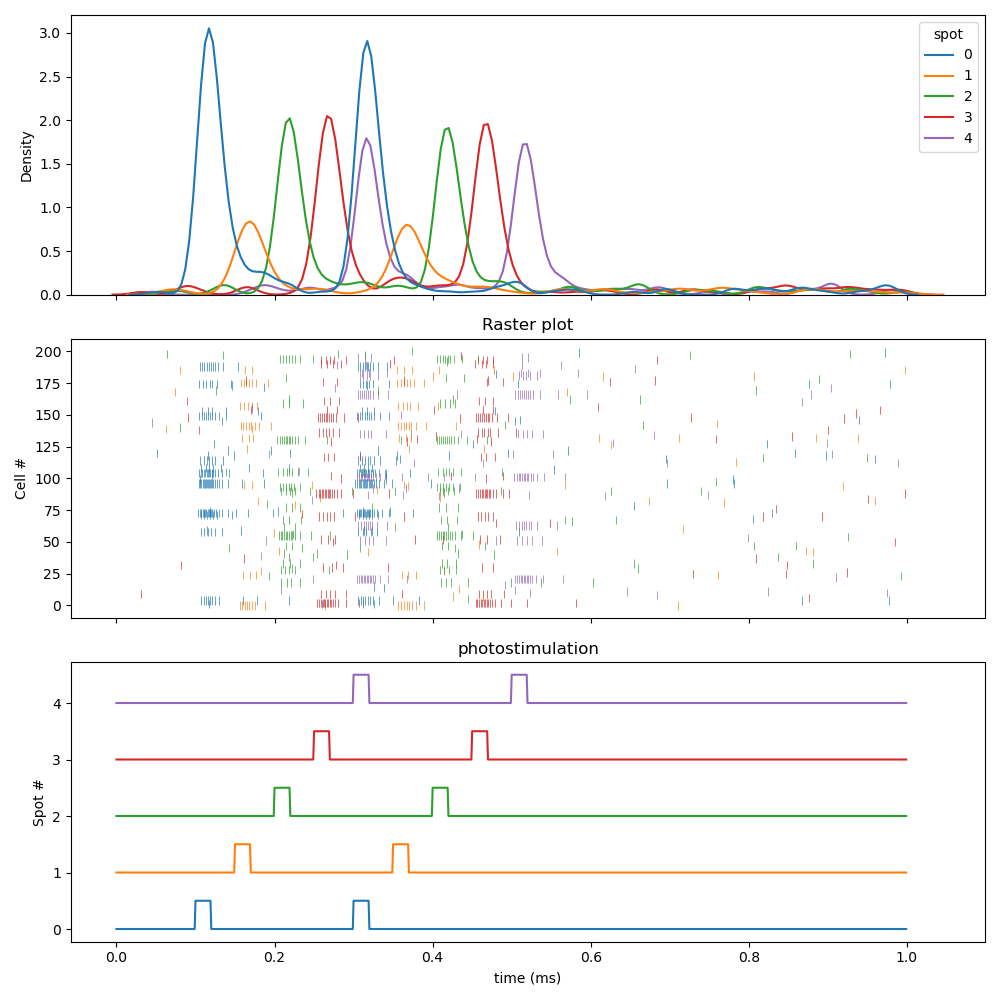

In [54]:
fig,ax = plt.subplots(3,1, sharex=True)

sns.kdeplot(ax=ax[0], data=spikes, x="spike_times", hue="spot", palette="tab10", bw_adjust=.2)

sns.scatterplot(data=spikes, x='spike_times', y='cellid', hue='spot', palette='tab10', marker='|', ax=ax[1])
ax[1].legend([], frameon=False)
ax[1].set(ylabel='Cell #', title='Raster plot',)

ax[2].plot(spots.t, spots.irradiance_ + np.arange(n_spots),)
ax[2].set(ylabel="Spot #",title="photostimulation", xlabel="time (ms)",)

# save figs
fig.set_size_inches(10, 10)
fig.tight_layout()
fig.savefig("optical_transfer_function_5spots_raster.png")
fig.savefig("optical_transfer_function_5spots_raster.svg")

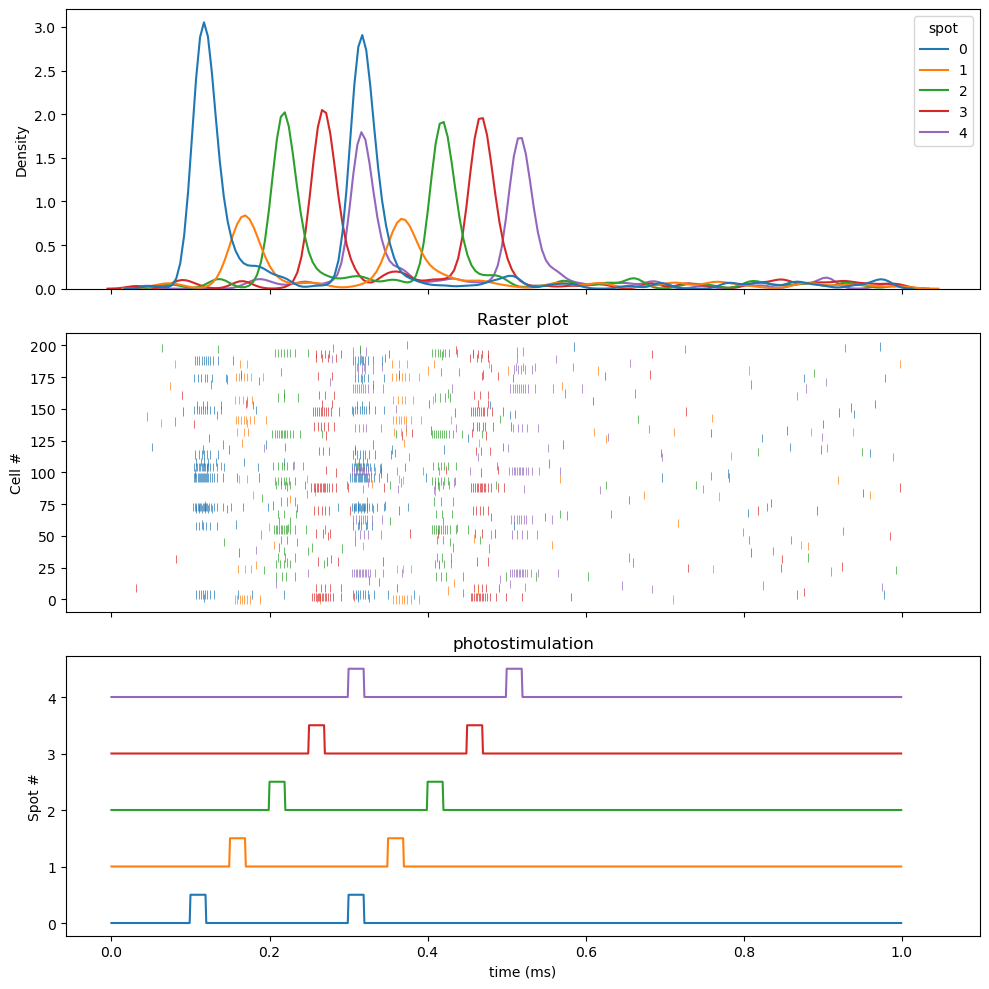

In [55]:
fig